In [1]:
from yugiquery import *

header("Speed Duel")

<div align='center'>
    <br>
    <!-- Pre Style needed to fix HTML formatting -->
    <pre style="line-height: var(--jp-code-line-height); font-family: var(--jp-code-font-family)">
    ██    ██ ██    ██  ██████  ██  ██████  ██    ██ ███████ ██████  ██    ██ 
     ██  ██  ██    ██ ██       ██ ██    ██ ██    ██ ██      ██   ██  ██  ██  
      ████   ██    ██ ██   ███ ██ ██    ██ ██    ██ █████   ██████    ████   
       ██    ██    ██ ██    ██ ██ ██ ▄▄ ██ ██    ██ ██      ██   ██    ██    
       ██     ██████   ██████  ██  ██████   ██████  ███████ ██   ██    ██    
                                      ▀▀                                     
    </pre>
</div>
<div align='right'>
    Speed Duel - Execution started 12/06/2023 04:16 UTC <br>
    By <b>Guilherme Ruiz</b>
</div>

---

Table of Contents
=================

*   [1  Data aquisition](#Data-aquisition)
    *   [1.1  Fetch online data](#Fetch-online-data)
    *   [1.2  Merge data](#Merge-data)
*   [2  Check changes](#Check-changes)
    *   [2.1  Load previous data](#Load-previous-data)
    *   [2.2  Generate changelog](#Generate-changelog)
    *   [2.3  Save data](#Save-data)
*   [3  Data visualization](#Data-visualization)
    *   [3.1  Skill cards](#Skill-cards)
        *   [3.1.1  Character](#Character)
        *   [3.1.2  Property](#Property)
    *   [3.2  Property](#Property)
    *   [3.3  Archseries](#Archseries)
    *   [3.4  TCG Speed Duel status](#TCG-Speed-Duel-status)
        *   *   [3.4.0.1  By card type](#By-card-type)
            *   [3.4.0.2  By monster type](#By-monster-type)
            *   [3.4.0.3  By archseries](#By-archseries)
        *   [3.4.1  TCG Speed Duel vs. TCG status](#TCG-Speed-Duel-vs.-TCG-status)
*   [4  Epilogue](#Epilogue)
    *   [4.1  HTML export](#HTML-export)
<!--     *   [4.2  Git](#Git) -->

# Data aquisition

## Fetch online data

In [2]:
# Timestamp
timestamp = pd.Timestamp.now()

In [3]:
# Fetch skill cards
skill_df = fetch_skill()

# Fetch deck cards
speed_df = fetch_speed()

123 results


1037 results


## Merge data

In [4]:
full_df = (
    pd.concat([speed_df, skill_df], ignore_index=True, axis=0)
    .sort_values("Name")
    .reset_index(drop=True)
)
print("Data merged")

Data merged

# Check changes

## Load previous data

In [5]:
# Get list of files
files_list = sorted(
    glob.glob("../data/all_speed_*.csv"), key=os.path.getctime, reverse=True
)
# Get second newest file if exist
if files_list:
    latest_file = files_list[0]
    # Load csv avoiding converting "NA" to NaN
    previous_df = pd.read_csv(
        latest_file, dtype=object, keep_default_na=False, na_values=[""]
    )
    # Correct tuples
    tuple_cols = ["Secondary type", "Effect type", "Archseries", "Artwork"]
    for col in tuple_cols:
        previous_df[col] = previous_df[col].dropna().apply(literal_eval)
    # Force dtypes to match current df
    previous_df = previous_df.astype(
        full_df[previous_df.columns.intersection(full_df.columns)].dtypes.to_dict()
    )
    previous_ts = pd.to_datetime(
        os.path.basename(latest_file).split("_")[-1].split(".csv")[0]
    )
    print("File loaded")
else:
    previous_df = None
    print("No older files")

File loaded

## Generate changelog

In [6]:
if previous_df is None:
    changelog = None
    print("Skipped")
else:
    changelog = generate_changelog(previous_df, full_df, col="Name")
    if not changelog.empty:
        display(changelog)
        changelog.to_csv(
            f'../data/speed_changelog_{previous_ts.isoformat(timespec="minutes")}_{timestamp.isoformat(timespec="minutes")}.csv',
            index=True,
        )
        print("Changelog saved")

,Archseries,Effect type,Modification date,Version
Name,,,,
Alpha The Magnet Warrior,"(Magnet Warrior, Warrior (archetype))",NaN,2023-03-18 00:32:56,Old
Alpha The Magnet Warrior,NaN,NaN,2023-03-18 00:32:56,New
Amazoness Fighter,"(Amazoness,)","(Continuous Effect,)",2023-04-10 17:19:17,Old
Amazoness Fighter,NaN,"(Continuous Effect,)",2023-04-10 17:19:17,New
Amazoness Fighting Spirit,"(Amazoness,)","(Continuous-like Effect,)",2023-04-10 17:19:10,Old
...,...,...,...,...
Z-Metal Tank,NaN,"(Continuous-like Effect, Ignition Effect, Igni...",2023-05-14 22:22:09,New
Zoma the Spirit,"(Trap Monster,)","(Effect, Trigger Effect)",2023-05-10 10:30:41,Old
Zoma the Spirit,NaN,"(Effect, Trigger Effect)",2023-05-10 10:30:41,New


Changelog saved

## Save data

In [7]:
if changelog is not None and changelog.empty:
    print("No changes. New data not saved")
else:
    full_df.to_csv(
        f'../data/all_speed_{timestamp.isoformat(timespec="minutes")}.csv', index=False
    )
    print("Data saved")

Data saved

# Data visualization

In [8]:
full_df

,Name,Password,Card type,Property,Archseries,Attribute,Primary type,Secondary type,Monster type,Effect type,DEF,ATK,Level/Rank,TCG status,OCG status,TCG Speed Duel status,Page name,Page URL,Artwork,Modification date,Character
0,7 Completed,86198326,Spell Card,Equip Spell Card,NaN,NaN,NaN,NaN,NaN,"(Condition, Continuous-like Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Unlimited,7 Completed,https://yugipedia.com/wiki/7_Completed,NaN,2023-05-15 19:27:15,NaN
1,A Cat of Ill Omen,24140059,Monster Card,NaN,NaN,DARK,Effect Monster,"(Flip monster,)",Beast,"(Flip effect,)",300,500,2,Unlimited,Unlimited,Unlimited,A Cat of Ill Omen,https://yugipedia.com/wiki/A_Cat_of_Ill_Omen,NaN,2023-03-17 23:24:44,NaN
2,A Hero Emerges,21597117,Trap Card,Normal Trap Card,NaN,NaN,NaN,NaN,NaN,"(Activation condition, Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Unlimited,A Hero Emerges,https://yugipedia.com/wiki/A_Hero_Emerges,NaN,2023-05-18 19:50:56,NaN
3,A Hero Lives,08949584,Spell Card,Normal Spell Card,NaN,NaN,NaN,NaN,NaN,"(Activation condition, Cost, Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Unlimited,A Hero Lives,https://yugipedia.com/wiki/A_Hero_Lives,NaN,2023-03-17 23:26:31,NaN
4,A Legendary Ocean,00295517,Spell Card,Field Spell Card,"(Umi (series),)",NaN,NaN,NaN,NaN,"(Condition, Continuous-like Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Unlimited,A Legendary Ocean,https://yugipedia.com/wiki/A_Legendary_Ocean,NaN,2023-03-17 23:26:47,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,Zombie Master,NaN,Skill Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Illegal,NaN,Legal,Zombie Master (Skill Card),https://yugipedia.com/wiki/Zombie_Master_(Skil...,NaN,2023-03-20 21:17:40,Bonz
1156,Zombie Tiger,47693640,Monster Card,NaN,NaN,EARTH,Effect Monster,"(Union monster,)",Zombie,"(Condition, Continuous-like Effect, Ignition E...",1600,1400,3,Unlimited,Unlimited,Unlimited,Zombie Tiger,https://yugipedia.com/wiki/Zombie_Tiger,NaN,2023-03-20 21:18:19,NaN
1157,Zombina,81616639,Monster Card,NaN,NaN,EARTH,Effect Monster,NaN,Zombie,"(Trigger Effect,)",1500,1400,4,Unlimited,Unlimited,Unlimited,Zombina,https://yugipedia.com/wiki/Zombina,NaN,2023-03-31 19:01:57,NaN
1158,Zombyra the Dark,88472456,Monster Card,NaN,NaN,DARK,Effect Monster,NaN,Warrior,"(Continuous Effect, Trigger Effect)",500,2100,4,Unlimited,Unlimited,Unlimited,Zombyra the Dark,https://yugipedia.com/wiki/Zombyra_the_Dark,"(Edited,)",2023-03-16 17:37:07,NaN


## Skill cards

### Character

In [9]:
print(
    "Total number of characters portrayed in skill cards:",
    skill_df["Character"].nunique(),
)

Total number of characters portrayed in skill cards:

47

In [10]:
skill_df.drop("Card type", axis=1).sort_values("Character")

,Name,Property,Archseries,Character,TCG status,TCG Speed Duel status,Page name,Page URL,Modification date
1,Ancient Ruler Rises,NaN,NaN,Abidos the Third,Illegal,Legal,Ancient Ruler Rises,https://yugipedia.com/wiki/Ancient_Ruler_Rises,2023-04-06 18:57:19
17,Cloudy Skies of Grey,NaN,NaN,Adrian Gecko,Illegal,Legal,Cloudy Skies of Grey,https://yugipedia.com/wiki/Cloudy_Skies_of_Grey,2023-04-06 18:56:41
40,Fog Warning,NaN,NaN,Adrian Gecko,Illegal,Legal,Fog Warning,https://yugipedia.com/wiki/Fog_Warning,2023-04-06 18:53:34
68,Machine Angel Ascension,NaN,"(Machine Angel,)",Alexis Rhodes,Illegal,Legal,Machine Angel Ascension,https://yugipedia.com/wiki/Machine_Angel_Ascen...,2023-03-19 13:50:34
22,Cyber Blade Fusion,NaN,"(Cyber, Fusion (archetype))",Alexis Rhodes,Illegal,Legal,Cyber Blade Fusion,https://yugipedia.com/wiki/Cyber_Blade_Fusion,2023-03-18 10:04:42
...,...,...,...,...,...,...,...,...,...
24,Dark Creation,NaN,NaN,Yubel (character),Illegal,Legal,Dark Creation,https://yugipedia.com/wiki/Dark_Creation,2023-04-06 18:57:50
20,Consumed By Darkness,Field Spell Card,NaN,Yubel (character),Illegal,Legal,Consumed By Darkness,https://yugipedia.com/wiki/Consumed_By_Darkness,2023-03-28 00:02:27
41,Forbidden Cyber Style Technique,NaN,"(Cyber,)",Zane Truesdale,Illegal,Legal,Forbidden Cyber Style Technique,https://yugipedia.com/wiki/Forbidden_Cyber_Sty...,2023-03-18 18:45:35
23,Cyberdark Style,NaN,"(Cyberdark,)",Zane Truesdale,Illegal,Legal,Cyberdark Style (Skill Card),https://yugipedia.com/wiki/Cyberdark_Style_(Sk...,2023-03-18 10:23:15


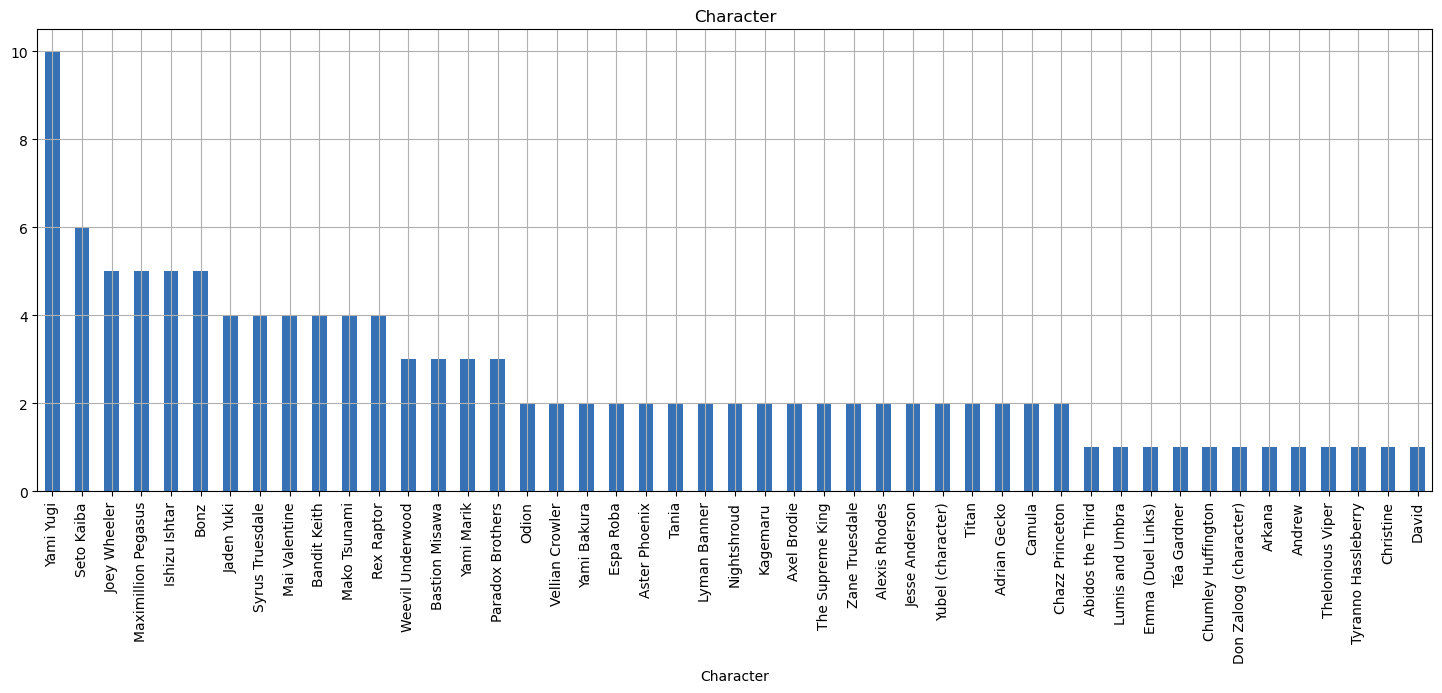

In [11]:
skill_color = colors_dict["Skill Card"]
skill_df["Character"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=90, color=skill_color, title="Character"
)
plt.show()

### Property

In [12]:
print("Total number of properties:", skill_df["Property"].nunique())

Total number of properties:

3

In [13]:
skill_df.groupby("Property").nunique()

,Name,Card type,Archseries,Character,TCG status,TCG Speed Duel status,Page name,Page URL,Modification date
Property,,,,,,,,,
Continuous Spell Card,3,1,1,3,1,1,3,3,3
Continuous Trap Card,1,1,0,1,1,1,1,1,1
Field Spell Card,10,1,2,10,1,1,10,10,10


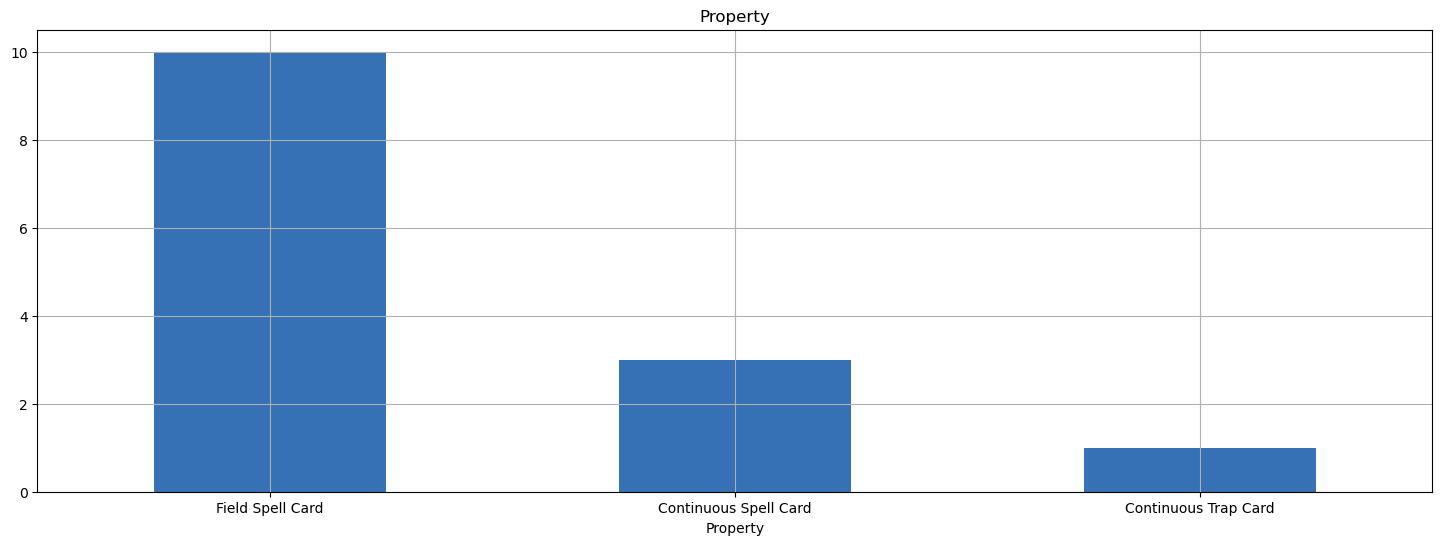

In [14]:
skill_color = colors_dict["Skill Card"]
skill_df["Property"].value_counts().plot.bar(
    figsize=(18, 6), grid=True, rot=0, color=skill_color, title="Property"
)
plt.show()

## Property

In [15]:
print("Total number of properties:", full_df["Property"].nunique())

Total number of properties:

9

In [16]:
full_df.groupby("Property").nunique()

,Name,Password,Card type,Archseries,Attribute,Primary type,Secondary type,Monster type,Effect type,DEF,ATK,Level/Rank,TCG status,OCG status,TCG Speed Duel status,Page name,Page URL,Artwork,Modification date,Character
Property,,,,,,,,,,,,,,,,,,,,
Continuous Spell Card,38,35,2,14,0,0,0,0,12,0,0,0,2,2,2,38,38,2,37,3
Continuous Trap Card,39,38,2,8,0,0,0,0,18,0,0,0,2,1,3,39,39,1,39,1
Counter Trap Card,12,12,1,2,0,0,0,0,3,0,0,0,1,1,1,12,12,1,12,0
Equip Spell Card,41,41,1,8,0,0,0,0,11,0,0,0,1,1,1,41,41,1,41,0
Field Spell Card,32,22,2,6,0,0,0,0,10,0,0,0,2,1,3,32,32,1,32,10
Normal Spell Card,113,113,1,19,0,0,0,0,18,0,0,0,2,2,3,113,113,2,113,0
Normal Trap Card,108,108,1,12,0,0,0,0,18,0,0,0,1,1,2,108,108,2,108,0
Quick-Play Spell Card,22,22,1,2,0,0,0,0,6,0,0,0,1,2,3,22,22,1,21,0
Ritual Spell Card,11,11,1,1,0,0,0,0,2,0,0,0,1,1,2,11,11,1,11,0


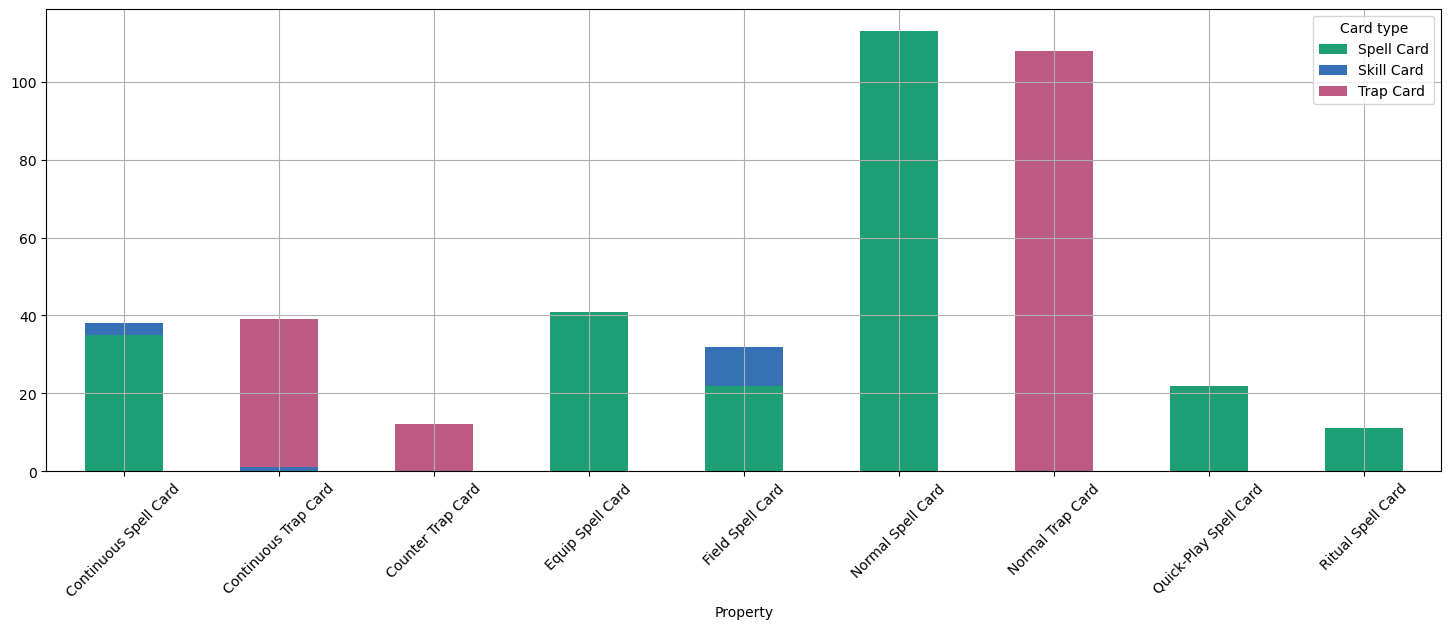

In [17]:
property_unstack = full_df.groupby("Property")["Card type"].value_counts().unstack()
skill_st_colors = [colors_dict[i] for i in property_unstack.columns]
property_unstack.plot.bar(
    figsize=(18, 6), stacked=True, grid=True, rot=45, color=skill_st_colors
)
plt.show()

## Archseries

In [18]:
exploded_archseries = full_df.explode("Archseries")
print("Total number of Archseries:", exploded_archseries["Archseries"].nunique())

Total number of Archseries:

134

In [19]:
exploded_archseries.groupby("Archseries").nunique()

,Name,Password,Card type,Property,Attribute,Primary type,Secondary type,Monster type,Effect type,DEF,ATK,Level/Rank,TCG status,OCG status,TCG Speed Duel status,Page name,Page URL,Artwork,Modification date,Character
Archseries,,,,,,,,,,,,,,,,,,,,
-Eyes Dragon,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0
A-to-Z,4,4,1,0,1,2,0,1,1,3,4,2,1,1,1,4,4,1,4,0
Aged counterpart,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0
Ally of Justice,2,2,1,0,1,2,0,1,1,2,2,2,1,1,1,2,2,0,2,0
Amazoness,11,11,3,4,1,1,0,2,10,6,5,3,1,1,1,11,11,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wight,3,3,2,1,1,2,0,1,2,2,2,1,1,1,1,3,3,0,3,0
Wingman,2,2,1,0,2,1,0,1,2,2,2,2,1,1,1,2,2,0,2,0
With Chain,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0


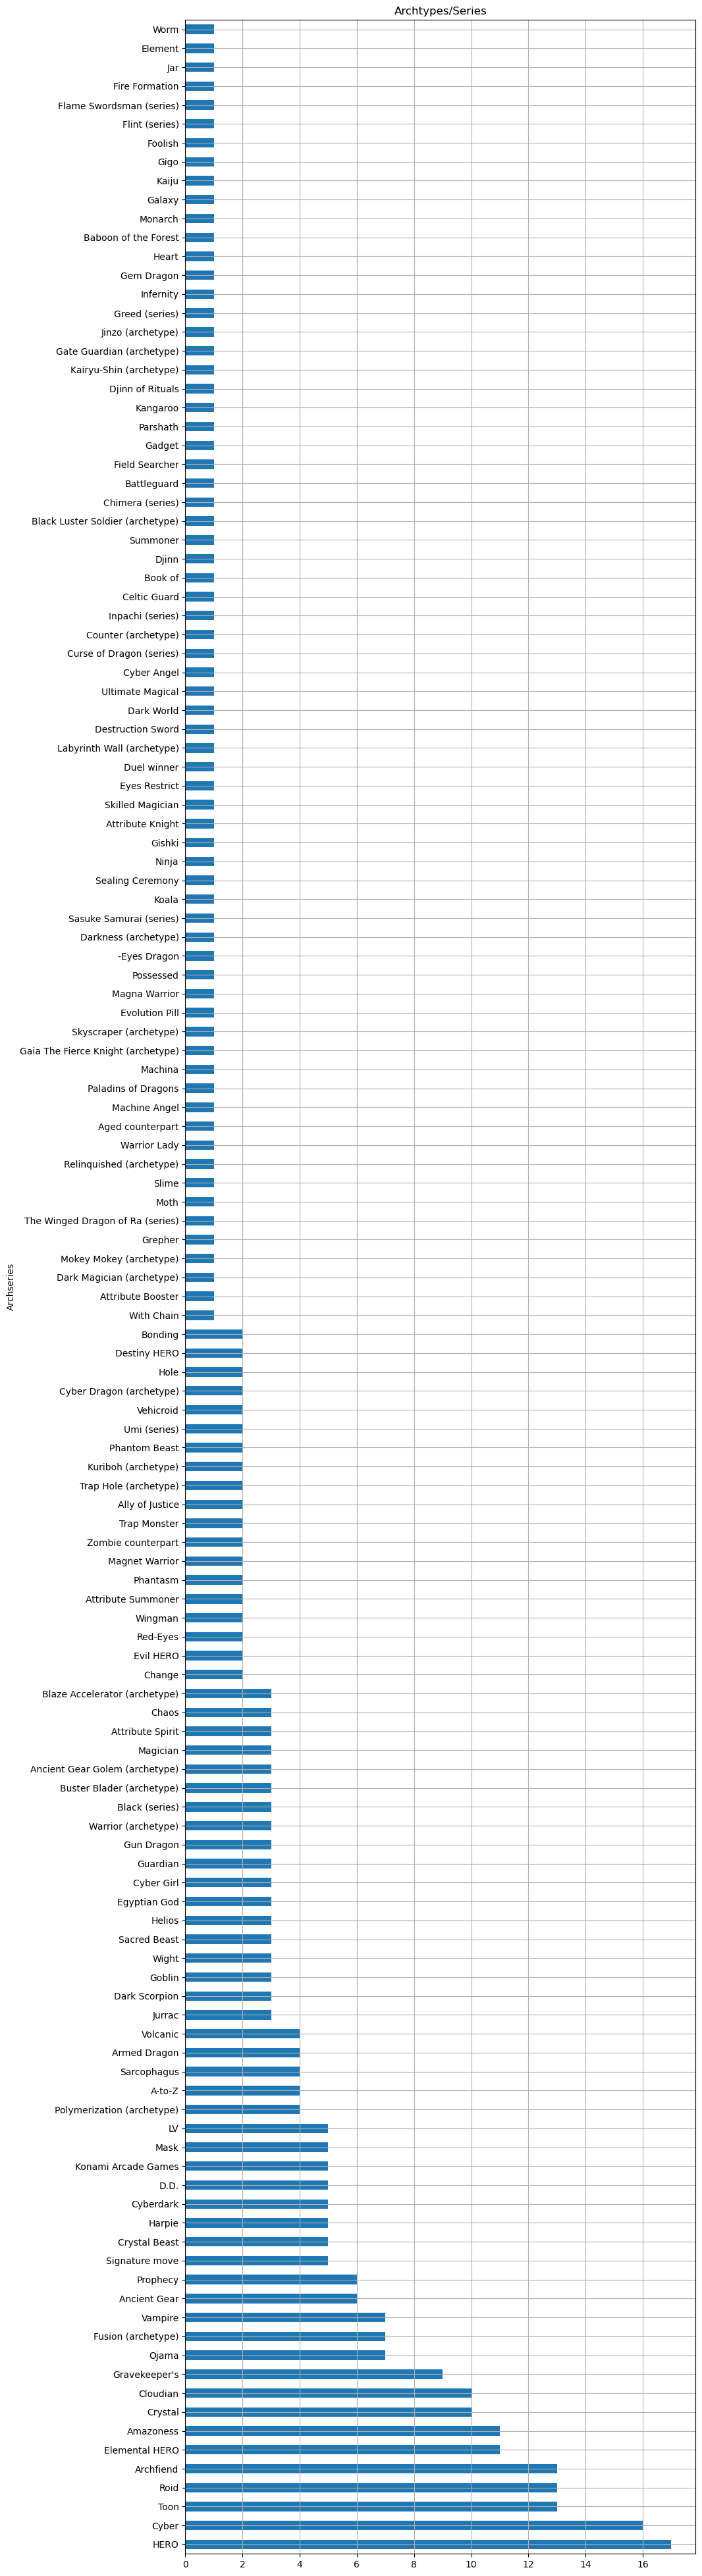

In [20]:
exploded_archseries["Archseries"].value_counts().plot.barh(
    figsize=(10, 50), grid=True, title="Archtypes/Series"
)
plt.show()

## TCG Speed Duel status

In [21]:
print(
    "Total number of TCG Speed Duel status:", full_df["TCG Speed Duel status"].nunique()
)

Total number of TCG Speed Duel status:

5

In [22]:
full_df.groupby("TCG Speed Duel status", dropna=False).nunique()

,Name,Password,Card type,Property,Archseries,Attribute,Primary type,Secondary type,Monster type,Effect type,DEF,ATK,Level/Rank,TCG status,OCG status,Page name,Page URL,Artwork,Modification date,Character
TCG Speed Duel status,,,,,,,,,,,,,,,,,,,,
Legal,120,0,1,3,20,0,0,0,0,0,0,0,0,1,0,120,120,0,120,47
Limited 1,5,5,3,3,1,1,1,0,1,4,1,1,1,2,2,5,5,2,5,0
Limited 2,7,6,3,2,1,3,1,0,2,5,2,3,2,3,2,7,7,1,7,1
Limited 3,12,10,4,3,4,2,2,0,4,8,3,4,3,2,1,12,12,2,12,2
Unlimited,1013,1010,3,9,133,7,4,4,20,114,46,56,12,2,2,1013,1013,3,977,0


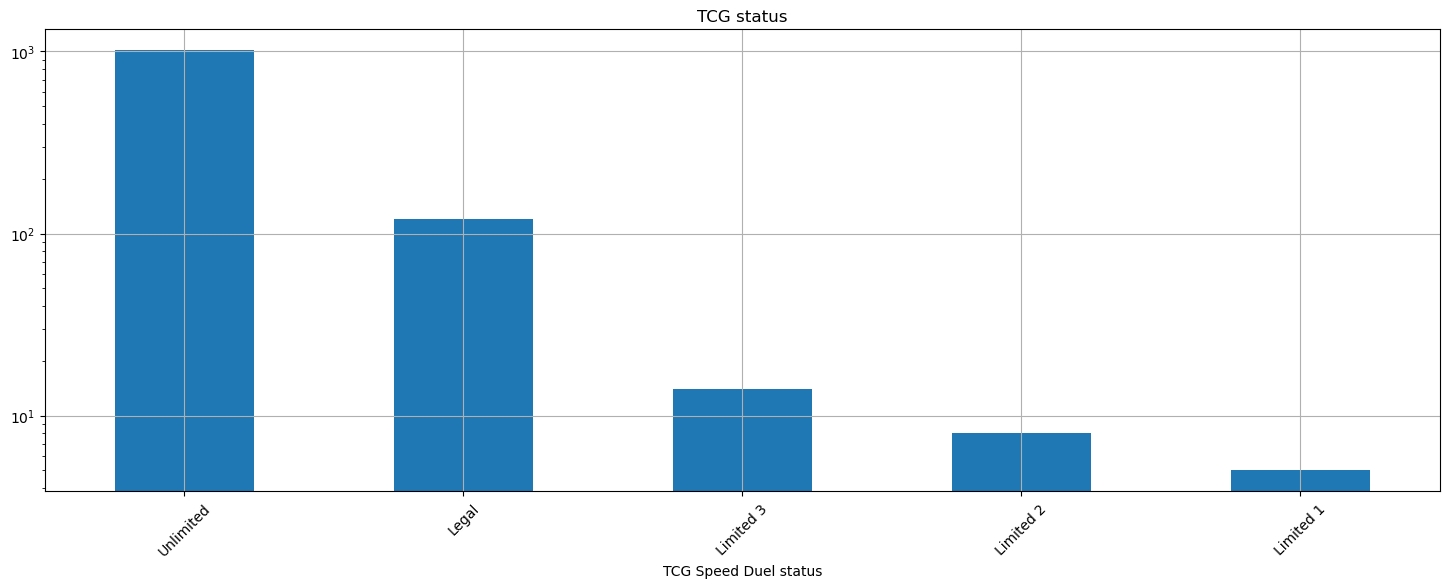

In [23]:
full_df["TCG Speed Duel status"].value_counts(dropna=False).plot.bar(
    figsize=(18, 6), logy=True, grid=True, rot=45, title="TCG status"
)
plt.show()

#### By card type

In [24]:
# Remove unlimited
tcg_speed_crosstab = pd.crosstab(full_df["Card type"], full_df["TCG Speed Duel status"])
tcg_speed_crosstab

TCG Speed Duel status,Legal,Limited 1,Limited 2,Limited 3,Unlimited
Card type,,,,,
Monster Card,0,1,3,4,624
Skill Card,120,0,2,4,0
Spell Card,0,2,3,3,236
Trap Card,0,2,0,3,153


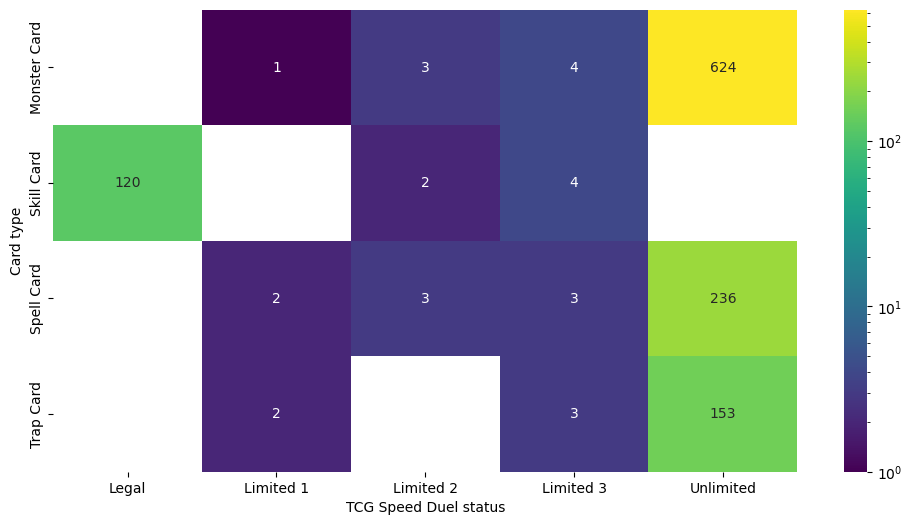

In [25]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    tcg_speed_crosstab[tcg_speed_crosstab > 0],
    annot=True,
    fmt="g",
    cmap="viridis",
    norm=mc.LogNorm(),
)
plt.show()

#### By monster type

In [26]:
# Remove unlimited
tcg_speed_crosstab_b = pd.crosstab(
    full_df["Monster type"], full_df["TCG Speed Duel status"]
)
tcg_speed_crosstab_b

TCG Speed Duel status,Limited 1,Limited 2,Limited 3,Unlimited
Monster type,,,,
Aqua,0,0,0,13
Beast,0,0,0,33
Beast-Warrior,0,0,0,14
Dinosaur,0,0,0,27
Divine-Beast,0,0,0,3
Dragon,0,0,0,44
Fairy,0,0,1,32
Fiend,0,0,0,95
Fish,0,0,0,6


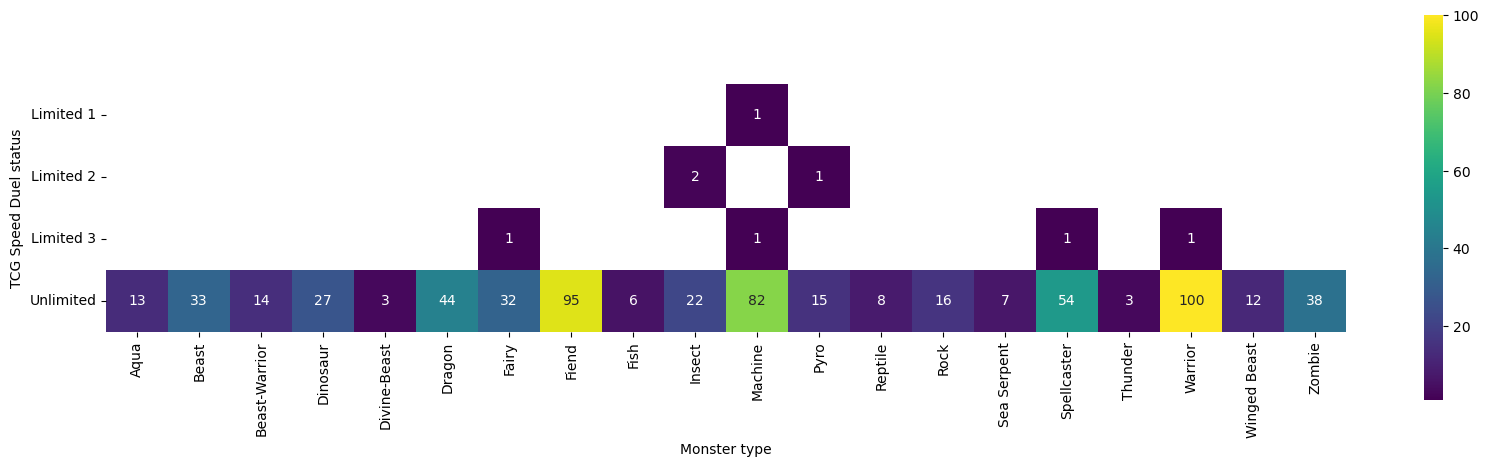

In [27]:
plt.figure(figsize=(20, 5))
sns.heatmap(
    tcg_speed_crosstab_b[tcg_speed_crosstab_b > 0].T,
    annot=True,
    fmt="g",
    cmap="viridis",
    square=True,
)
plt.show()

#### By archseries

In [28]:
# Remove unlimited
tcg_crosstab_c = pd.crosstab(
    exploded_archseries["Archseries"],
    exploded_archseries["TCG Speed Duel status"],
    margins=True,
)
tcg_crosstab_c

TCG Speed Duel status,Legal,Limited 1,Limited 2,Limited 3,Unlimited,All
Archseries,,,,,,
-Eyes Dragon,0,0,0,0,1,1
A-to-Z,0,0,0,0,4,4
Aged counterpart,0,0,0,0,1,1
Ally of Justice,0,0,0,0,2,2
Amazoness,0,0,0,0,11,11
...,...,...,...,...,...,...
Wingman,0,0,0,0,2,2
With Chain,0,0,0,0,1,1
Worm,0,0,0,0,1,1


### TCG Speed Duel vs. TCG status

In [29]:
cg_crosstab = pd.crosstab(
    full_df["TCG status"], full_df["TCG Speed Duel status"], dropna=False, margins=False
)
cg_crosstab

TCG Speed Duel status,Legal,Limited 1,Limited 2,Limited 3,Unlimited
TCG status,,,,,
Illegal,120,0,2,4,0
Limited,0,1,1,0,0
Semi-Limited,0,0,0,0,1
Unlimited,0,4,5,10,1012


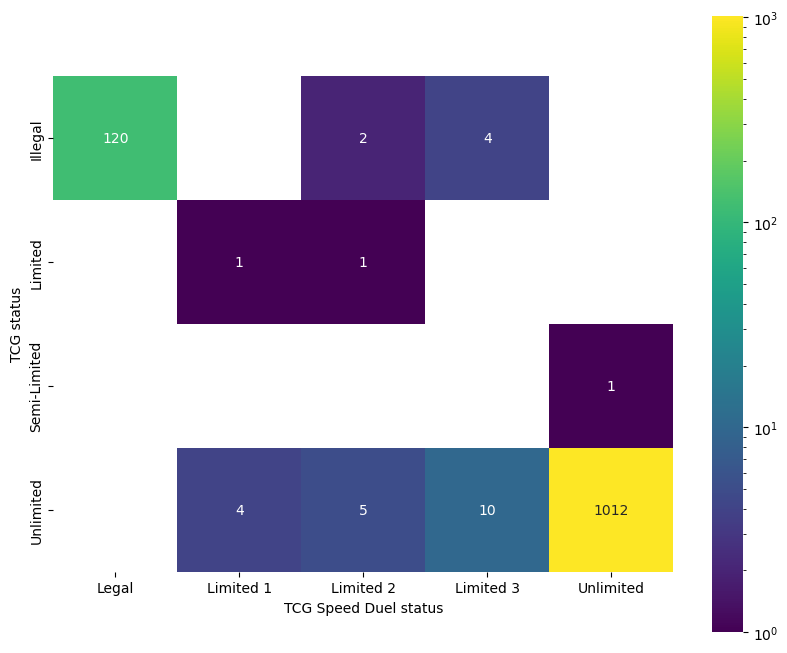

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cg_crosstab[cg_crosstab > 0],
    annot=True,
    fmt="g",
    cmap="viridis",
    square=True,
    norm=mc.LogNorm(),
)
plt.show()

# Epilogue

In [31]:
benchmark("speed", timestamp)

In [32]:
footer()

<div align='right'>
    Execution completed 12/06/2023 04:16 UTC
</div>

## HTML export

In [33]:
# Save notebook on disck before generating HTML report
save_notebook()

Notebook saved to disk

In [34]:
! jupyter nbconvert Speed.ipynb --output-dir='../' --to=HTML --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='exclude' --TemplateExporter.exclude_input=True --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook Speed.ipynb to HTML


[NbConvertApp] Writing 1468541 bytes to ../Speed.html


## Git

In [ ]:
! git add "../*[Ss]peed*"

In [ ]:
! git commit -m {"'Speed duel update-" + timestamp.isoformat() + "'"}